# Data Science with Covid-19

## Loading and preprocessing of data

As a data source, we are using the Covid-19 Datahub supplied by the Robert-Koch-Institut (RKI), which provides all PCR-confirmed Cases which are sent in by the Gesundheitsämter.

We use the Arcgis-API to load the current data for Bavaria from the Datahub and store it into a CSV-file.

In [3]:
import requests

csv_data_req = requests.get('https://opendata.arcgis.com/api/v3/datasets/45258e51f57d43efb612f700a876ae8f_0/downloads/data?format=csv&spatialRefId=4326')
if csv_data_req.ok:
    with open('./data.txt', 'w') as file:
        csv_data = csv_data_req.text
        file.write(csv_data)
else:
    raise Exception

For further processing, we now load the data into a Pandas-Dataframe.  
Next, we filter the data for a specific IdLandkreis, in our case 9162, which represents the City of Munich. We can easily switch out this Id for another to look at another municipality.
Below, you will see a part of the data printed in tabluar form.

In [300]:
import pandas as pd

MUNICIPALITY_ID_MUC = 9162

cov_data_full = pd.read_csv('./data.txt', delimiter=',')
cov_data_full.Refdatum = pd.to_datetime(cov_data_full.Refdatum)
cov_data_full.Meldedatum = pd.to_datetime(cov_data_full.Meldedatum)
filter_lk = cov_data_full.IdLandkreis == MUNICIPALITY_ID_MUC
cov_data_muc = cov_data_full[filter_lk]


In [301]:
print(cov_data_muc)

       ï»¿IdBundesland Bundesland  IdLandkreis    Landkreis Altersgruppe  \
4433                 9     Bayern         9162  SK MÃ¼nchen      A00-A04   
4434                 9     Bayern         9162  SK MÃ¼nchen      A00-A04   
4435                 9     Bayern         9162  SK MÃ¼nchen      A00-A04   
4437                 9     Bayern         9162  SK MÃ¼nchen      A00-A04   
4455                 9     Bayern         9162  SK MÃ¼nchen      A00-A04   
...                ...        ...          ...          ...          ...   
23195                9     Bayern         9162  SK MÃ¼nchen         A80+   
23196                9     Bayern         9162  SK MÃ¼nchen         A80+   
23197                9     Bayern         9162  SK MÃ¼nchen         A80+   
23198                9     Bayern         9162  SK MÃ¼nchen         A80+   
23199                9     Bayern         9162  SK MÃ¼nchen         A80+   

            Altersgruppe2 Geschlecht                Meldedatum  \
4433   Nicht Ã¼bermit

We aggregate the data by its Refdatum, which represents the date of infection, or, if this is unknown, the date when the case became known to the public health ministry.
Additionally, we calculate the cumulative sum over all days for later use.

In [298]:
#cov_data_per_day = cov_data_muc.query('IstErkrankungsbeginn == 1').groupby('Meldedatum').sum()
cov_data_per_day = cov_data_muc.groupby('Refdatum').sum()
cov_data_cumulative = cov_data_per_day.cumsum()

## Set up common functions and defaults

Next, we set up some defaults and common functions which we will later use for plotting our data.

In [8]:
import matplotlib as plt
# Set style / color scheme for plots
plt.style.use('seaborn')

In [67]:
# Convenience function for setting up a plot, optionally with a second axis of cases relative to 100.000 inhabitants, and predefined axis labels

def setup_cases_plot(include_per_100k = True):
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    ax.set_ylabel('Infektionen')
    ax.set_xlabel('Tag der Erkrankung oder Tag der Meldung wenn Unbekannt')
    if include_per_100k:
        secax_y = ax.secondary_yaxis('right', functions=(abs_to_per_100k, per_100k_to_abs))
        secax_y.set_ylabel('Infektionen pro 100.000 Einwohner')
    return fig, ax

In [10]:
EW_DATA_MUC = 1488202 # Source: Landesamt für Statistik Bayern, https://www.statistikdaten.bayern.de/genesis/online?language=de&sequenz=tabellen&selectionname=12411-001*

abs_to_per_100k = lambda a: (a / EW_DATA_MUC) * 100000
per_100k_to_abs = lambda p: (p * EW_DATA_MUC) / 100000

## Cumulative sum of cases over the whole timespan of the pandemic

We now plot the cumulative sum of all Cases in Munich over the whole timespan. We also create a second y-Axis for the plot which shows the cumulative sum as Cases per 100.000 Inhabitants.

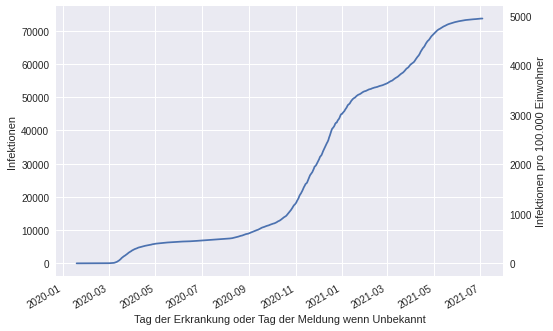

In [68]:
import matplotlib.pyplot as plt
# Kumulative Fälle absolut + pro 100.000 EW

fig, ax = setup_cases_plot()

ax.plot(cov_data_cumulative['AnzahlFall'])

plt.savefig('cases_cumulative.png')

## Daily cases

Next, we plot the daily new cases over the whole timespan. We can now already clearly see the three waves which occurred until now, one in Spring 2020, one in Winter 2020/2021 and one in early Summer 2021.

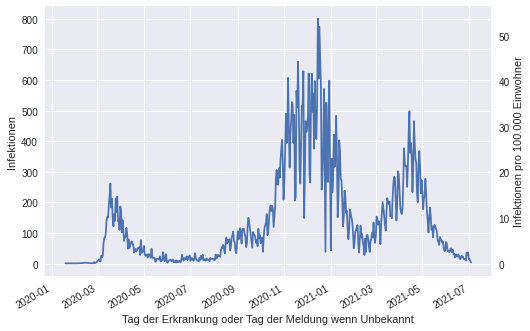

In [69]:
import matplotlib.pyplot as plt
# Tägliche Fälle absolut + pro 100.000 EW

fig, ax = setup_cases_plot()

ax.plot(cov_data_per_day['AnzahlFall'])

plt.savefig('cases_per_day.png')

## 7 day Incidence

To calculate the 7 day incidence, we calculate the rolling sum of cases over 7 days, divide this value by the number of Inhabitants of Munich and then multiply it by 100.000, thus yielding the 7 day incidence as the rolling sum of cases over 7 days per 100.000 Inhabitants.

In [13]:
cases_7_days = cov_data_per_day.rolling('7d').sum()
incidence_7_days = cases_7_days / EW_DATA_MUC * 100000

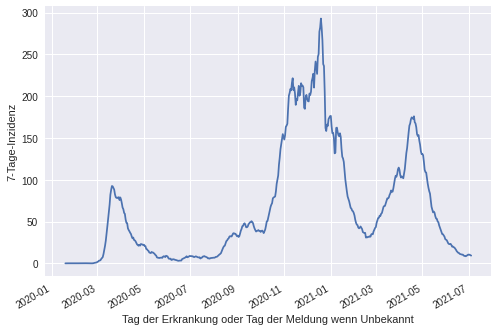

In [72]:
import matplotlib.pyplot as plt
# /-Tage-Inzidenz

fig, ax = setup_cases_plot(include_per_100k=False)

ax.plot(incidence_7_days['AnzahlFall'])
ax.set_ylabel("7-Tage-Inzidenz")

plt.savefig('7_day_incidence.png')

## Cases, Deaths and Recoveries

We now additionally look at the deaths and recoveries, once as a plot of per-day-events, once as a cumulative sum.
Here we can already see that the death rate was highest in the second wave, though it is hard to clearly see as the difference between cases and deaths is quite big.
We will look at a better plot for this in the next paragraph.

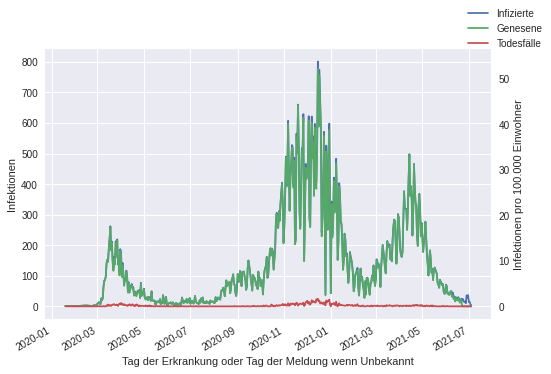

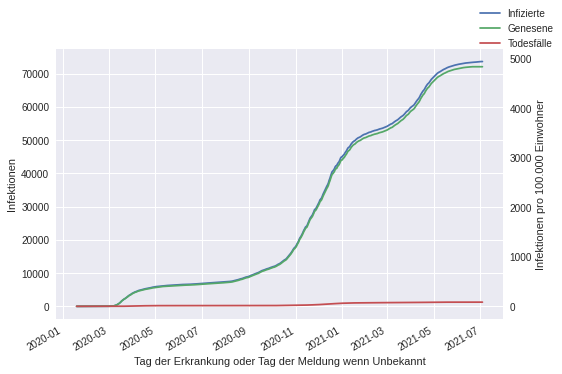

In [299]:
import matplotlib.pyplot as plt
# Tägliche Fälle / Todesfälle / Genesungen absolut + pro 100.000 EW

fig, ax = setup_cases_plot()

ax.plot(cov_data_per_day['AnzahlFall'], label="Infizierte")
ax.plot(cov_data_per_day['AnzahlGenesen'], label="Genesene")
ax.plot(cov_data_per_day['AnzahlTodesfall'], label="Todesfälle")

fig.legend()
plt.savefig('cases_with_deaths_and_recoveries.png')

fig, ax = setup_cases_plot()

ax.plot(cov_data_cumulative['AnzahlFall'], label="Infizierte")
ax.plot(cov_data_cumulative['AnzahlGenesen'], label="Genesene")
ax.plot(cov_data_cumulative['AnzahlTodesfall'], label="Todesfälle")

fig.legend()
plt.savefig('cases_with_deaths_and_recoveries_cumulative.png')

## 7 day incidence and death rate

In this graphic, we compare the 7 day incidence to the scaled cumulative sum of deaths over 7 days.  
Here we can see the relationships between cases and deaths way more easily.  
The plot clearly shows that in the first two waves, the deaths followed the incidence quite closely.  
This relationship does not hold true that strongly, however, in the third wave, which can be likely attributed to increased vaccination numbers.  
Since more people are vaccinated, those who catch the virus and have had at least one dose of a two dose vaccine are significantly less likely to be hospitalized or die, which is seen reflected in the data.

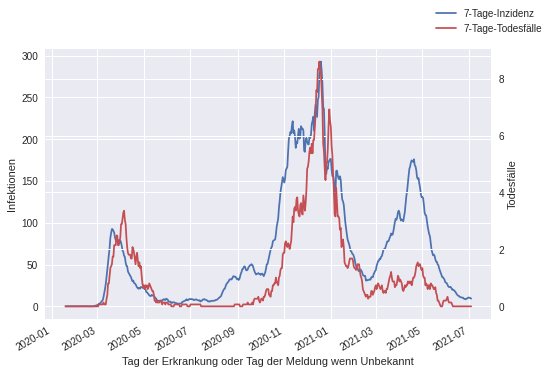

In [74]:
import matplotlib.pyplot as plt
# 7-Tage-Inzidenz und Todesfälle, skaliert auf den jeweils höchsten Wert

fig, ax = setup_cases_plot(False)

ax.plot(incidence_7_days['AnzahlFall'], label="7-Tage-Inzidenz")
ax2 = ax.twinx()
ax2.set_ylabel("Todesfälle")
ax2.plot(incidence_7_days['AnzahlTodesfall'], label="7-Tage-Todesfälle", color="C2")
fig.legend()

plt.savefig('cases_with_deaths_and_recoveries_twinax.png')

# Covid-19 Waves and exponential growth

## Covid-19 Waves over the rolling 7 day Cases

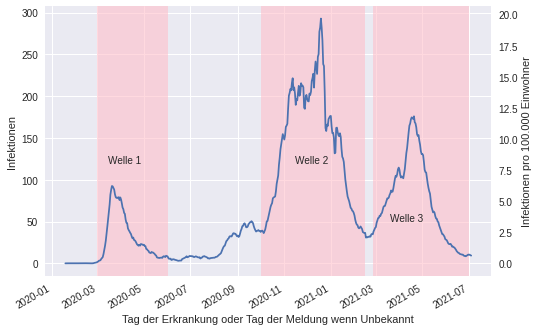

In [75]:
import matplotlib.pyplot as plt
import datetime as dt
# Wellen über die 7-Tage-Inzidenz

fig, ax = setup_cases_plot()

ax.plot(incidence_7_days['AnzahlFall'])
ax.axvspan(dt.datetime(2020, 3, 1), dt.datetime(2020, 6, 1), facecolor='pink', edgecolor='none', alpha=.6)
ax.text(dt.datetime(2020, 3, 15), 120, "Welle 1")
ax.axvspan(dt.datetime(2020, 10, 1), dt.datetime(2021, 2, 15), facecolor='pink', edgecolor='none', alpha=.6)
ax.text(dt.datetime(2020, 11, 15), 120, "Welle 2")
ax.axvspan(dt.datetime(2021, 2, 25), dt.datetime(2021, 7, 1), facecolor='pink', edgecolor='none', alpha=.6)
ax.text(dt.datetime(2021, 3, 20), 50, "Welle 3")

plt.savefig("waves.png")

## Cumulative Sum of Cases, semi-log plot

Here we see the cumulative sum of cases over the whole timespan of the pandemic, plotted in a semi-logarithimc (log-linear) plot, where the cases are on a logarithimc scale, while the time remains linear.

In this diagram we can see that the exponential-growth parts of the curve appear mostly linear, and the beginning of the first wave is clearly visible, which is obscured in the pure linear plot.

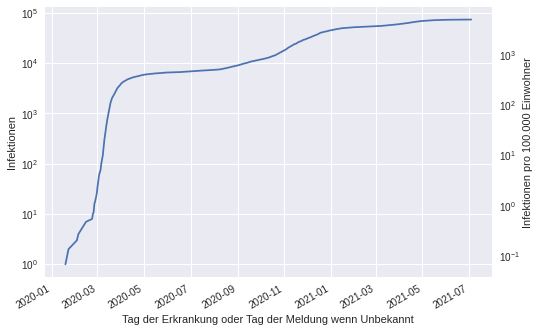

In [126]:
import matplotlib.pyplot as plt
# Tägliche Fälle + pro 100.000 EW

fig, ax = setup_cases_plot()

ax.plot(cov_data_cumulative['AnzahlFall'])
ax.set_yscale('log')

#ax2 = ax.twinx()

#ax2.plot(cov_data_cumulative['AnzahlFall'])
plt.savefig("partial_log_cumulative.png")

## Fitting of e-Function over the cumulative cases

We now use a linear least squares regression to fit an $e$-Function over the cumulative sum of cases.
This way, we can approximate the exponential growth and see the waves more easily.

To fit the e-Function via linear least squares, we can transform and thus linearize our equation.
$$f(x_i) = a e^{b x_i}$$
can be transformed to 
$$\ln{f(x_i)} = \ln{a} + b x_i$$
by using the natural logarithm on both sides.
This is a linear equation that we can easily fit using a linear least squares approach.
We create our Matrix $A$ from our $x$-Values and the Vector $b$ by taking the $\ln$ of our $y$-Values, and set up our least-squares-equation $$A^TAx = A^Tb$$
By solving this system we obtain our two parameters $\ln{a}$ and $b$, of which we can use $b$ right away. $\ln{a}$ can be turned back to $a$ by simply taking $e$ to the power again, as $e^{\ln{a}} = a$.

In [332]:
import numpy as np

def linear_regression(b, x):
    A = np.column_stack((np.ones(x.size), x))
    AT = A.transpose()
    ATA = AT.dot(A)
    ATb = AT.dot(b)

    return np.linalg.solve(ATA, ATb)

In [333]:
def e_transformed_linear_regression(data):
    b = np.log(np.array(data))
    x_vector = np.arange(0, b.size)
    fit = linear_regression(b, x_vector)
    return (np.exp(fit[0]), fit[1])

# y = a * np.exp(b * x_vector)

First, we will do a regression over the whole time period. As we see, this is not very accurate, as the time is too long and the data varies too much.
Thus, we will do a regression for a shorter window at a time to see the change in growth.

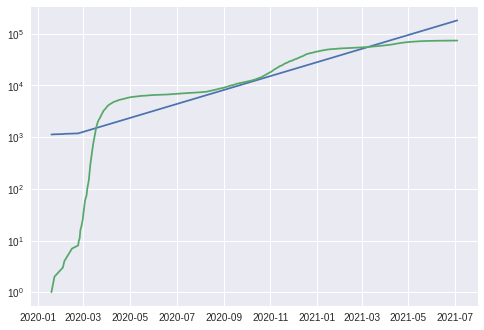

In [319]:
import matplotlib.pyplot as plt
import pandas as pd
# Regression over the whole time period


a,b = e_transformed_linear_regression(cov_data_cumulative['AnzahlFall'].values)
y = a * np.exp(b * x_vector)


fig, ax = plt.subplots()

ax.plot(cov_data_cumulative.index, y)

ax.plot(cov_data_cumulative['AnzahlFall'])
ax.set_yscale('log')

Here, we are fitting over a shorter timespan of 7 datapoints to see the actual change in growth. This makes the waves quite well visible, and shows that there is actually exponential growth happening in the waves.

In [379]:
import matplotlib.pyplot as plt

def plot_cumsum_with_regressions(data, window_size):

    fig, ax = plt.subplots()

    ax.plot(data['AnzahlFall'].cumsum())
    ax.set_yscale('log')
    fig.autofmt_xdate()
    
    i = 0
    while i<=data.index.size - window_size:
        a,b = e_transformed_linear_regression(data['AnzahlFall'].values[i:i+window_size])
        y = a * np.exp(b * np.arange(0, window_size))
        ax.plot(data.index[i:i+window_size], y)
        i += window_size + 1

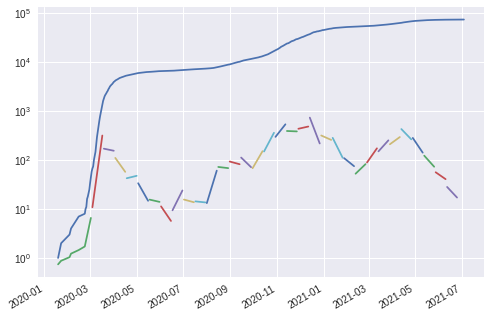

In [380]:
plot_cumsum_with_regressions(cov_data_per_day, 14)

In the plots of the single waves, we can clearly see the exponential growth, until it reaches a tipping point and the cases flatten off.
The first wave is the most pronounced here, while the second and third wave are dragged out a little longer, with a stagnation of cases in the middle before the exponential growth starts again.

In [377]:
cov_data_first_wave = cov_data_per_day.loc[(cov_data_per_day.index < pd.to_datetime('07/01/2020 00:00', utc=True))]

cov_data_second_wave = cov_data_per_day.loc[(cov_data_per_day.index > pd.to_datetime('10/01/2020 00:00', utc=True)) & (cov_data_per_day.index < pd.to_datetime('02/01/2021 00:00', utc=True))]

cov_data_third_wave = cov_data_per_day.loc[(cov_data_per_day.index > pd.to_datetime('02/20/2021 00:00', utc=True)) & (cov_data_per_day.index < pd.to_datetime('07/29/2021 00:00', utc=True))]

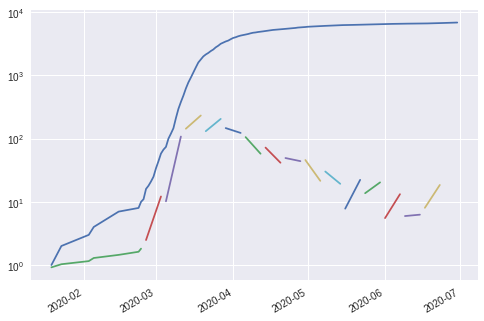

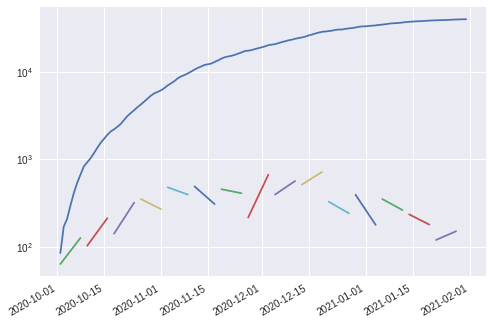

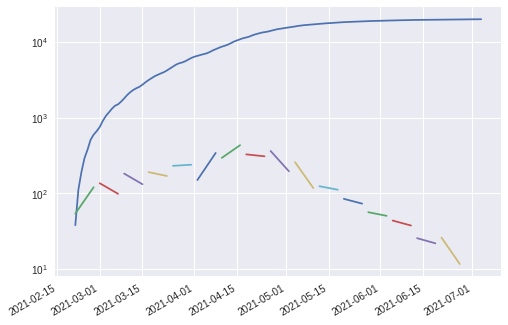

In [381]:
plot_cumsum_with_regressions(cov_data_first_wave, 7)
plot_cumsum_with_regressions(cov_data_second_wave, 7)
plot_cumsum_with_regressions(cov_data_third_wave, 7)

# Variation in cases and deaths by demographic factors

## LogLog Plots of 7 day rolling Cases vs Cumulative Cases for all three Waves

Here we plot the rolling 7 day sum of cases versus the cumulative sum of cases for all three waves as loglog-Plots, with both x and y Axis logarithmic.
This shows us the exponential growth phases as straight lines, with their slope corresponding to the growth rate, so the exponent of the equation $y = ax^n$.

We can clearly see that all three waves have a very distinct exponential growth phase, until they reach a turning point and the growth rate declines in direction of stagnation.

In [293]:
import pandas as pd
cov_data_third_wave = cov_data_per_day.loc[(cov_data_per_day.index > pd.to_datetime('02/20/2021 00:00', utc=True)) & (cov_data_per_day.index < pd.to_datetime('07/29/2021 00:00', utc=True))]

rolling_cases_third_wave = cov_data_third_wave.rolling('7d').sum()['AnzahlFall'].values
rolling_cumulative_third_wave = cov_data_third_wave.cumsum()['AnzahlFall'].values

cov_data_first_wave = cov_data_per_day.loc[(cov_data_per_day.index < pd.to_datetime('07/01/2020 00:00', utc=True))]

rolling_cases_first_wave = cov_data_first_wave.rolling('7d').sum()['AnzahlFall'].values
rolling_cumulative_first_wave = cov_data_first_wave.cumsum()['AnzahlFall'].values

cov_data_second_wave = cov_data_per_day.loc[(cov_data_per_day.index > pd.to_datetime('10/01/2020 00:00', utc=True)) & (cov_data_per_day.index < pd.to_datetime('02/01/2021 00:00', utc=True))]

rolling_cases_second_wave = cov_data_second_wave.rolling('7d').sum()['AnzahlFall'].values
rolling_cumulative_second_wave = cov_data_second_wave.cumsum()['AnzahlFall'].values

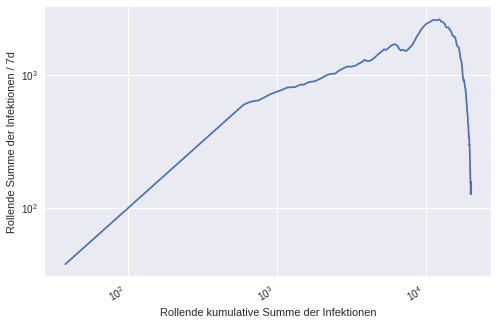

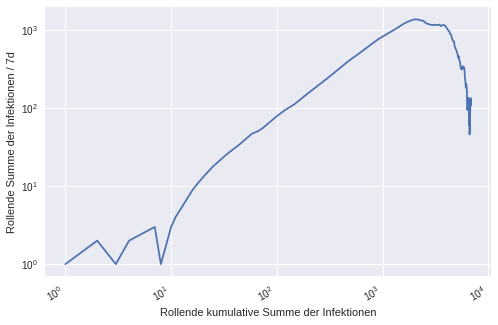

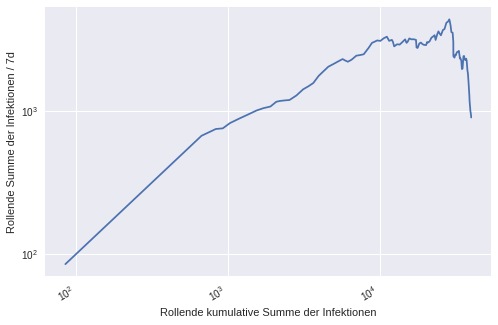

In [294]:
import matplotlib.pyplot as plt
# loglog Plot von 7-Tagessummen der Fälle gegen kumulative Summen der Fälle für die drei Wellen

fig, ax = plt.subplots(1,1)

ax.plot(rolling_cumulative_first_wave, rolling_cases_first_wave)
ax.set_ylabel('Rollende Summe der Infektionen / 7d')
ax.set_xlabel('Rollende kumulative Summe der Infektionen')
ax.loglog()
fig.autofmt_xdate()

plt.savefig("rolling_sum_versus_cumulative_first.png")

fig, ax = plt.subplots(1,1)

ax.plot(rolling_cumulative_second_wave, rolling_cases_second_wave)
ax.set_ylabel('Rollende Summe der Infektionen / 7d')
ax.set_xlabel('Rollende kumulative Summe der Infektionen')
ax.loglog()
fig.autofmt_xdate()

plt.savefig("rolling_sum_versus_cumulative_second.png")

fig, ax = plt.subplots(1,1)

ax.plot(rolling_cumulative_third_wave, rolling_cases_third_wave)
ax.set_ylabel('Rollende Summe der Infektionen / 7d')
ax.set_xlabel('Rollende kumulative Summe der Infektionen')
ax.loglog()
fig.autofmt_xdate()

plt.savefig("rolling_sum_versus_cumulative_third.png")

## Cases by Gender

We now plot the Cases by Gender, which shows that in the first two waves both genders were nearly equal in case numbers and movement of case numbers.
The cumulative plot shows, however, that in the third wave, females were are slightly less often infected than males.
This can have many reasons, one might be the higher number of women over 80 Years compared to men, and their earlier vaccination, though without further data this is purely speculative.

In [382]:
cov_data_per_day_male = cov_data_muc.query('Geschlecht == "M"').groupby('Refdatum').sum().rolling('7d').sum()
cov_data_per_day_female = cov_data_muc.query('Geschlecht == "W"').groupby('Refdatum').sum().rolling('7d').sum()

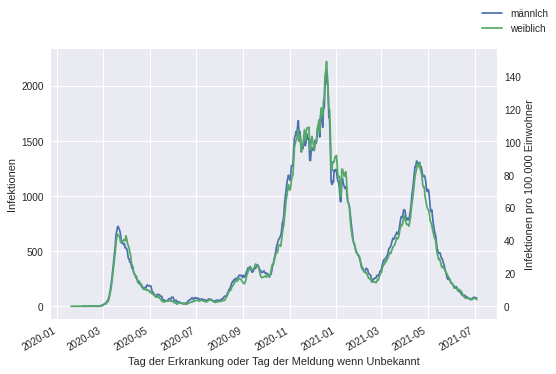

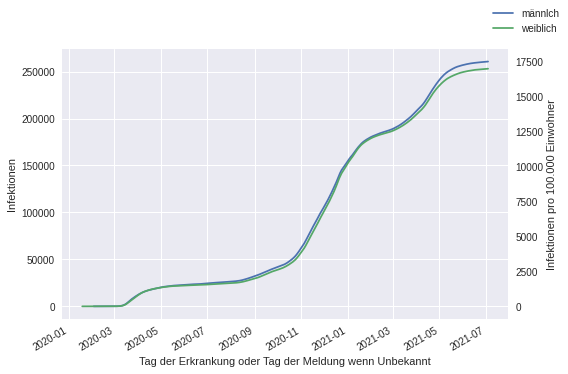

In [383]:
import matplotlib.pyplot as plt
# Fälle nach Geschlecht

fig, ax = setup_cases_plot()

ax.plot(cov_data_per_day_male['AnzahlFall'], label="männlch")
ax.plot(cov_data_per_day_female['AnzahlFall'], label="weiblich")
fig.legend()

plt.savefig("cases_by_gender.png")

# Kumulative Fälle nach Geschlecht

fig, ax = setup_cases_plot()

ax.plot(cov_data_per_day_male['AnzahlFall'].cumsum(), label="männlch")
ax.plot(cov_data_per_day_female['AnzahlFall'].cumsum(), label="weiblich")
fig.legend()

plt.savefig("cases_by_gender_cumulative.png")

In [398]:
cov_data_male_by_age_single = cov_data_muc.query('Geschlecht == "M"').groupby(['Refdatum','Altersgruppe'], as_index=False).sum()
cov_data_male_by_age_multi = {}
for agegroup in cov_data_male_by_age_single['Altersgruppe'].unique():
    cov_data_male_by_age_multi[agegroup] = cov_data_male_by_age_single[cov_data_male_by_age_single['Altersgruppe'] == agegroup].set_index('Refdatum')

cov_data_female_by_age_single = cov_data_muc.query('Geschlecht == "W"').groupby(['Refdatum','Altersgruppe'], as_index=False).sum()
cov_data_female_by_age_multi = {}
for agegroup in cov_data_female_by_age_single['Altersgruppe'].unique():
    cov_data_female_by_age_multi[agegroup] = cov_data_female_by_age_single[cov_data_female_by_age_single['Altersgruppe'] == agegroup].set_index('Refdatum')

In the following plot we now split the gender-cases-plot by agegroups, which shows that the gender-disparity is also present in the agegroups 15-34 and 35-59, which voids our theory from above. Alternative theories could include males exhibiting more risky behavior in general, but this theory would need further evaluation.

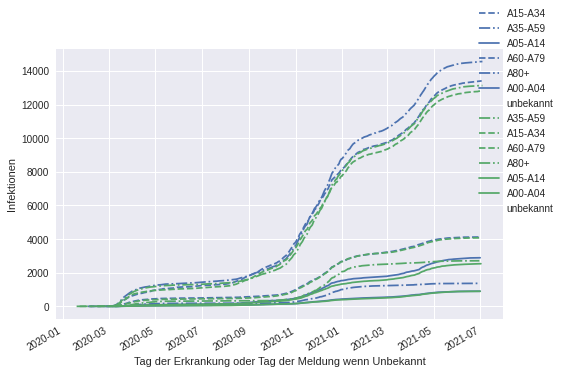

In [405]:
from labellines import labelLine, labelLines

fig, ax = setup_cases_plot(False)

linetypes = {
    "A15-A34": "dashed",
    "A35-A59": "dashdot",
    "A05-A14": "solid",
    "A60-A79": "dashed",
    "A80+": "dashdot",
    "A00-A04": "solid",
    "unbekannt": "none"
}

for (key, agegroup_data) in cov_data_male_by_age_multi.items():
    ax.plot(agegroup_data.cumsum()['AnzahlFall'], label=key, ls=linetypes[key], color="C0")
for (key, agegroup_data) in cov_data_female_by_age_multi.items():
    ax.plot(agegroup_data.cumsum()['AnzahlFall'], label=key, ls=linetypes[key], color="C1")

fig.legend()
#labelLines(plt.gca().get_lines(),align=False,fontsize=14)

## Cases and Deaths by Agegroup

Lastly, we compare cases and deaths by agegroup.
Here we can clearly see that the most deaths occurred in the agegroups 60-79 Years and above 80 Years, even though significantly more infections occurred in the agegroups between 15 and 59, which shows the significantly higher mortality for people 60 and above.

In [24]:

cov_data_by_age_single = cov_data_muc.groupby(['Refdatum','Altersgruppe'], as_index=False).sum()
cov_data_by_age_multi = {}
for agegroup in cov_data_by_age_single['Altersgruppe'].unique():
    cov_data_by_age_multi[agegroup] = cov_data_by_age_single[cov_data_by_age_single['Altersgruppe'] == agegroup].set_index('Refdatum')

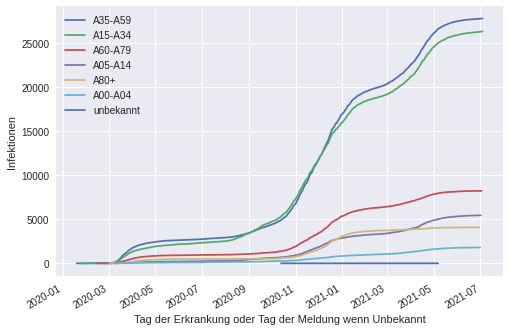

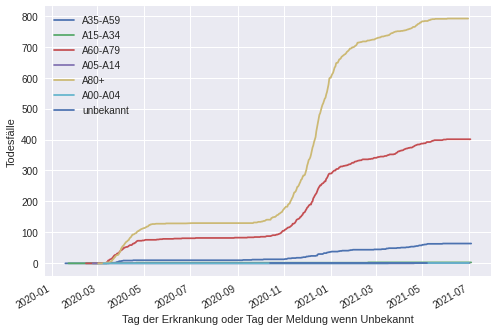

In [98]:
import matplotlib.pyplot as plt
# Sterblichkeit und Fälle nach Altersgruppen

fig, ax = setup_cases_plot(False)

for (key, agegroup_data) in cov_data_by_age_multi.items():
    ax.plot(agegroup_data.cumsum()['AnzahlFall'], label=key)
ax.legend()

plt.savefig("cases_by_age_group.png")


fig, ax = setup_cases_plot(False)

for (key, agegroup_data) in cov_data_by_age_multi.items():
    ax.plot(agegroup_data.cumsum()['AnzahlTodesfall'], label=key)
ax.legend()
ax.set_ylabel("Todesfälle")

plt.savefig("deaths_by_age_group.png")
